In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from scipy.stats import ttest_ind
from scipy.stats import wasserstein_distance
import ast

In [2]:
def byte_frequency(file_path):
    """
    Extract byte frequency distribution of a file.
    """
    with open(file_path, 'rb') as f:
        byte_content = f.read()
    byte_content = byte_content[4:-4]  # remove first and last 4 bytes
    byte_frequency = [byte_content.count(i) for i in range(256)]
    return byte_frequency


def extract_multiple_reference_byte_frequency(directory, reference_csv_file, file_types):
    """
    Extract byte frequency of all files in a directory and save to reference CSV file.
    """
    reference_byte_frequency = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        _, file_extension = os.path.splitext(file_name)
        file_extension = file_extension[1:] # remove the leading "."
        if file_extension in file_types:
            byte_freq = byte_frequency(file_path)
            reference_byte_frequency.append({'file_type': file_extension, 'byte_frequency': byte_freq})
    reference_byte_frequency_df = pd.DataFrame(reference_byte_frequency)
    reference_byte_frequency_df.to_csv(reference_csv_file, index=False)

In [3]:
file_types = ['csv', 'doc', 'gif', 'gz', 'html', 'jpg', 'log', 'pdf', 'png', 'ppt', 'ps', 'txt', 'xls', 'xml']
#extract_multiple_reference_byte_frequency('statistical', 'reference_byte_frequency.csv', file_types)

In [4]:
from scipy.stats import pearsonr
from scipy.spatial.distance import dice
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from scipy.stats import entropy
import numpy as np

def correlation(byte_frequency1, byte_frequency2):
    """
    Calculate correlation between two byte frequency distributions.
    """
    corr, p_value = pearsonr(byte_frequency1, byte_frequency2)
    return corr

def intersection(byte_frequency1, byte_frequency2):
    """
    Calculate intersection between two byte frequency distributions.
    """
    return dice(byte_frequency1, byte_frequency2)

def chi2_distance(byte_frequency1, byte_frequency2):
    """
    Calculate chi-square distance between two byte frequency distributions.
    """
    contingency_table = np.array([byte_frequency1, byte_frequency2]) + 1
    _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

def kolmogorov_smirnov(byte_frequency1, byte_frequency2):
    """
    Calculate Kolmogorov-Smirnov distance between two byte frequency distributions.
    """
    ks_statistic, p_value = ks_2samp(byte_frequency1, byte_frequency2)
    return ks_statistic

def anderson_darling(byte_frequency1, byte_frequency2):
    """
    Calculate Anderson-Darling distance between two byte frequency distributions.
    """
    a2, critical_values, significance_level = anderson_ksamp([byte_frequency1, byte_frequency2])
    return a2

def kullback_leibler(byte_frequency1, byte_frequency2):
    """
    Calculate Kullback-Leibler divergence between two byte frequency distributions.
    """
    kl = entropy(byte_frequency1, byte_frequency2)
    return kl

def jensen_shannon(byte_frequency1, byte_frequency2):
    """
    Calculate Jensen Shannon divergence between two byte frequency distributions.
    """
    # calculate the frequency distributions
    p = byte_frequency1 / np.sum(byte_frequency1)
    q = byte_frequency2 / np.sum(byte_frequency2)
    # calculate the average frequency distribution
    m = 0.5 * (p + q)
    # calculate the Jensen-Shannon divergence
    jsd = 0.5 * (entropy(p, m) + entropy(q, m))
    return jsd
def bhattacharya_distance(byte_frequency1, byte_frequency2):
    """
    Calculate Bhattacharya distance between two byte frequency distributions.
    """
    dot_product = np.dot(np.sqrt(byte_frequency1), np.sqrt(byte_frequency2))
    return -np.log(dot_product)

def kullback_leibler1(byte_frequency1, byte_frequency2):
    """
    Calculate Kullback-Leibler divergence between two byte frequency distributions.
    """
    byte_frequency1 = np.array(byte_frequency1, dtype=np.float64)
    byte_frequency2 = np.array(byte_frequency2, dtype=np.float64)
    byte_frequency1 = byte_frequency1 / byte_frequency1.sum()
    byte_frequency2 = byte_frequency2 / byte_frequency2.sum()
    kl = np.sum(np.where(byte_frequency1 != 0, byte_frequency1 * np.log2(byte_frequency1 / (byte_frequency2 + 1e-10)), 0))
    return kl

In [14]:
def compare_files(new_files, reference_csv_file, threshold, label_map):
  
    reference_byte_frequency = pd.read_csv(reference_csv_file)
    total_accuracy = 0
    total_predictions = []
    total_true_labels = []
    for new_file in new_files:
        true_label = new_file.split('/')[-1].split('.')[1]
        byte_frequency_new_file = byte_frequency(new_file)
        similarities = []
        for i in range(len(reference_byte_frequency)):
            bfr = ast.literal_eval(reference_byte_frequency.at[i, 'byte_frequency'])
            bfr = [int(x) for x in bfr]
            similarities.append(jensen_shannon(byte_frequency_new_file, bfr))
            #print('value', kullback_leibler1(byte_frequency_new_file, bfr))
        _, p_value = ttest_ind(similarities, [0]*len(similarities))
        #print('pvalue', p_value)
        if p_value < threshold:
            min_similarity = float('inf')
            file_type = None
            for i, similarity in enumerate(similarities):
                #print('similarity', similarity)
                if similarity < min_similarity:
                    min_similarity = similarity
                    file_type = reference_byte_frequency.at[i, 'file_type']
            predictions_num = label_map[file_type]
            true_labels_num = label_map[true_label]
            #predictions_num = file_type
            #true_labels_num = true_label
            total_predictions.append(predictions_num)
            total_true_labels.append(true_labels_num)
    accuracy = accuracy_score(total_true_labels, total_predictions)
    print(classification_report(total_true_labels, total_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], target_names=list(label_map.keys())))
    print("Accuracy:", accuracy)
    #conf_matrix = confusion_matrix(total_true_labels, total_predictions, labels=list(label_map.keys()))
    labels = list(label_map.keys())
    conf_matrix = confusion_matrix(total_true_labels, total_predictions)
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="w")
    plt.show()
    print("Confusion Matrix:")
    print(conf_matrix)
    return accuracy

In [15]:
new_files = ['021/021034.jpg', '021/021013.pdf', '021/021006.doc']
label_map = {'csv' : 0, 'doc' : 1, 'gif' : 2, 'gz' : 3, 'html' : 4, 'jpg' : 5, 'log' : 6, 'pdf' : 7, 'png' : 8, 'ppt' : 9, 'ps' : 10, 'txt' : 11, 'xls' : 12, 'xml' : 13}
#compare_files(new_files, 'reference_byte_frequency.csv', 0.5, label_map)

C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

         csv       0.94      0.85      0.89        20
         doc       0.98      0.95      0.97        66
         gif       0.92      0.92      0.92        12
          gz       0.85      0.69      0.76        16
        html       0.96      0.97      0.97       276
         jpg       0.98      0.69      0.81        67
         log       0.89      0.89      0.89         9
         pdf       0.94      1.00      0.97       261
         png       0.00      0.00      0.00         3
         ppt       0.73      0.98      0.83        44
          ps       0.89      0.80      0.84        10
         txt       0.93      0.92      0.93       133
         xls       0.98      0.96      0.97        46
         xml       1.00      0.71      0.83         7

    accuracy                           0.94       970
   macro avg       0.86      0.81      0.83       970
weighted avg       0.94      0.94      0.93       970

Accuracy: 0.9360824742268

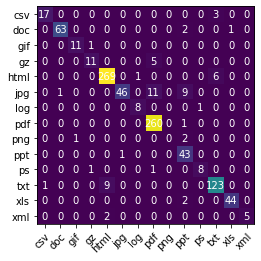

Confusion Matrix:
[[ 17   0   0   0   0   0   0   0   0   0   0   3   0   0]
 [  0  63   0   0   0   0   0   0   0   2   0   0   1   0]
 [  0   0  11   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   5   0   0   0   0   0   0]
 [  0   0   0   0 269   0   1   0   0   0   0   6   0   0]
 [  0   1   0   0   0  46   0  11   0   9   0   0   0   0]
 [  0   0   0   0   0   0   8   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0 260   0   1   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0  43   0   0   0   0]
 [  0   0   0   1   0   0   0   1   0   0   8   0   0   0]
 [  1   0   0   0   9   0   0   0   0   0   0 123   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0  44   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0   0   5]]


0.9360824742268041

In [16]:
import os
import glob
from os import listdir
from os.path import isfile, join

cwd = 'C:\\Users\\Razaq\\Jupyter\\021'
#new_files = [os.path.join(cwd, f) for f in os.listdir(cwd) if 
#os.path.isfile(os.path.join(cwd, f))]
new_files = []

#for file in glob.glob(r'C:\\Users\\Razaq\\Jupyter\\021' +  '**\*.csv|*.doc|*.gif|*.gz|*.html|*.jpg|*.log|*.pdf|*.png|*.ppt|*.ps|*.txt|*.xls|*.xml'):
#    new_files.append(file)
label_map = {'csv' : 0, 'doc' : 1, 'gif' : 2, 'gz' : 3, 'html' : 4, 'jpg' : 5, 'log' : 6, 'pdf' : 7, 'png' : 8, 'ppt' : 9, 'ps' : 10, 'txt' : 11, 'xls' : 12, 'xml' : 13}
included_extensions = ['csv', 'doc', 'gif', 'gz', 'html', 'jpg', 'log', 'pdf', 'png', 'ppt', 'ps', 'txt', 'xls', 'xml']
new_files = [os.path.join(cwd, fn) for fn in os.listdir(cwd)
              if any(fn.endswith(ext) for ext in included_extensions)]

compare_files(new_files, 'reference_byte_frequency.csv', 0.5, label_map)